# Datos descargados de: https://www.pmel.noaa.gov/tao/drupal/disdel/



---


# PERFIL VERTICAL DE "TEMPERATURA SUB SUPERFICIAL DEL MAR" DE LA BOYA UBICADA EN 0°N 170°W

---



In [175]:
# Conectando google drive con colab:
#-------------------------------------
from google.colab import drive
drive.mount('/content/drive/')
#-------------------------------------
import os
path = '/content/drive/MyDrive/Colab Notebooks/OCEANOGRAFIA/BOYA 0N170W/' # Ruta del directorio de trabajo
os.chdir(path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [176]:
import pandas as pd
import xarray as xr
import numpy as np

In [177]:
Tsub = xr.open_dataset(path + 't0n170w_dy.cdf',
                       drop_variables = ['time_bnds','ST_6020','QT_5020','ZSST_2003','depzsst']) # Eliminamos variable inservibles.
Tsub['time'] = pd.date_range('1988-05-16', '2023-07-10', freq = 'D')
Tsub

<xarray.Dataset>
Dimensions:  (time: 12839, depth: 20, lat: 1, lon: 1)
Coordinates:
  * time     (time) datetime64[ns] 1988-05-16 1988-05-17 ... 2023-07-10
  * depth    (depth) float32 1.0 5.0 9.0 10.0 13.0 ... 200.0 250.0 300.0 500.0
  * lat      (lat) float32 0.0
  * lon      (lon) float32 190.0
Data variables:
    T_20     (time, depth, lat, lon) float32 ...
Attributes:
    platform_code:                0n170w
    site_code:                    0n170w
    wmo_platform_code:            51010
    array:                        TAO/TRITON
    Request_for_acknowledgement:  If you use these data in publications or pr...
    Data_Source:                  Global Tropical Moored Buoy Array Project O...
    File_info:                    Contact: Dai.C.McClurg@noaa.gov
    missing_value:                1e+35
    _FillValue:                   1e+35
    CREATION_DATE:                07:45 12-JUL-2023

In [178]:
# En este caso vamos a eliminar lat y lon ya que no lo utilizaremos:
ds = Tsub.sel(lat=Tsub.lat, lon=Tsub.lon, method='nearest')
# Elimina las dimensiones que no deseas (lat y lon)
ds = ds.squeeze(drop=True)
ds

<xarray.Dataset>
Dimensions:  (time: 12839, depth: 20)
Coordinates:
  * time     (time) datetime64[ns] 1988-05-16 1988-05-17 ... 2023-07-10
  * depth    (depth) float32 1.0 5.0 9.0 10.0 13.0 ... 200.0 250.0 300.0 500.0
Data variables:
    T_20     (time, depth) float32 ...
Attributes:
    platform_code:                0n170w
    site_code:                    0n170w
    wmo_platform_code:            51010
    array:                        TAO/TRITON
    Request_for_acknowledgement:  If you use these data in publications or pr...
    Data_Source:                  Global Tropical Moored Buoy Array Project O...
    File_info:                    Contact: Dai.C.McClurg@noaa.gov
    missing_value:                1e+35
    _FillValue:                   1e+35
    CREATION_DATE:                07:45 12-JUL-2023

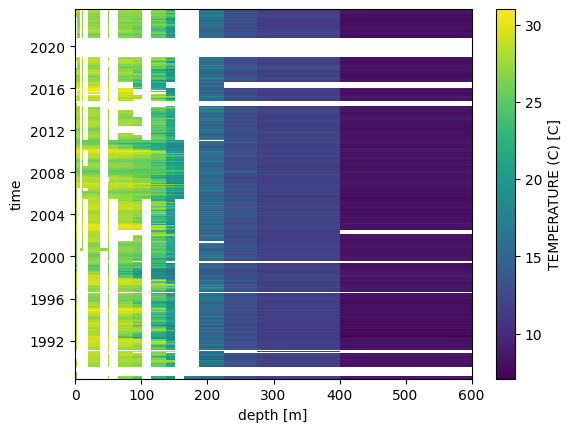

In [179]:
# Observación rápida
ds.T_20.plot() # Hay muchas profundidades con datos faltantes (vacíos)




---
# Debemos de eliminar las profundidades con menor cantidad de datos.
Para ello observaremos sus estadísticos (donde aparecerá el conteo de datos)

---



In [180]:
# Resumen estadístico con las estadísticas en orden predeterminado
conteo = ds.to_dataframe().reset_index().pivot(index='time', columns='depth', values='T_20').describe(percentiles=[0.25, 0.5, 0.75], include='all')

# Ordenar las estadísticas
# orden_estadisticas = ['count', 'mean', 'std', 'max', 'min', '25%', '50%', '75%']
orden_estadisticas = ['count', 'std', 'max', 'min']
conteo_ordenado = conteo.reindex(orden_estadisticas)
conteo_ordenado

depth,1.0,5.0,9.0,10.0,13.0,25.0,49.0,50.0,53.0,75.0,100.0,103.0,125.0,150.0,153.0,175.0,200.0,250.0,300.0,500.0
count,10277.000000,5270.000000,120.000000,7543.000000,1421.000000,11287.000000,120.000000,11031.000000,2039.000000,10671.000000,10444.000000,2039.000000,11426.000000,11342.000000,2039.000000,108.000000,11426.000000,11349.000000,11362.000000,11216.000000
std,1.222665,1.184979,0.254086,1.182001,1.304754,1.182538,0.266707,1.250506,1.337284,1.409061,1.877260,1.699532,2.346674,2.376399,1.972930,1.016525,1.193347,0.529341,0.352369,0.282019
max,30.969999,30.827959,28.000000,30.999506,30.320000,30.829180,27.900000,30.682398,30.480000,30.697933,30.459999,30.200001,30.389999,29.129999,28.040001,19.049999,24.200001,15.790000,13.113479,9.830000
min,24.090000,24.400000,27.020000,24.360001,24.400000,23.730000,26.740000,23.110001,23.850000,21.600000,18.020000,19.910000,16.549999,15.080000,15.910000,14.210000,12.760000,11.371746,10.590000,7.080000




---


# Eliminamos las profundidades con cantidad de datos menores al 70% del máximo de datos.
[5,9,13,49,53,103,153,175]

---



In [181]:
# Eliminamos las profundidades con pocos datos
profundidades_eliminar = [5,9,10,13,49,53,103,153,175]
# Eliminamos y la asignamos a la misma variable de los datos observados
ds = ds.drop_sel(depth=profundidades_eliminar)



---


 # CALCULAMOS EL PROMEDIO HISTÓRICO DIARIO (CLIM: 1991-01-01 - 2020-12-31)

---



In [182]:
year_inicio = 1991
year_fin = 2020
ds_prom = ds.sel(time=slice(f'{year_inicio}-01-01', f'{year_fin}-12-31')).groupby('time.dayofyear').mean(dim='time')
ds_prom.T_20.values

array([[27.669628 , 27.568014 , 27.582228 , ..., 12.889848 , 11.712959 ,
         8.309711 ],
       [27.654772 , 27.56199  , 27.589802 , ..., 12.969916 , 11.71557  ,
         8.288393 ],
       [27.695566 , 27.589155 , 27.616676 , ..., 12.983789 , 11.722932 ,
         8.3456335],
       ...,
       [27.705929 , 27.528704 , 27.536072 , ..., 12.966431 , 11.725541 ,
         8.2568445],
       [27.69941  , 27.554602 , 27.52382  , ..., 12.923713 , 11.707983 ,
         8.302111 ],
       [27.466593 , 27.255161 , 27.199518 , ..., 12.984313 , 11.69828  ,
         8.315618 ]], dtype=float32)

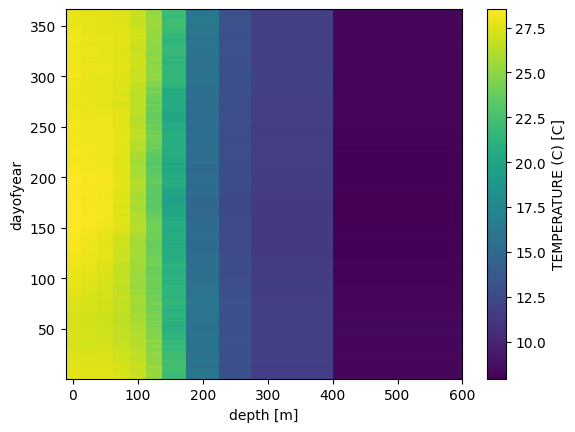

In [183]:
# Observamos que por defecto las profundidades se posicionan en el EJE X.
# Necesitamos que se posicione en el EJE Y.
ds_prom.T_20.plot()

In [184]:
# Transponer las dimensiones para que depth vaya primero
ds_prom = ds_prom.transpose('depth', 'dayofyear')
ds_prom['T_20']

<xarray.DataArray 'T_20' (depth: 11, dayofyear: 366)>
array([[27.669628 , 27.654772 , 27.695566 , ..., 27.705929 , 27.69941  ,
        27.466593 ],
       [27.568014 , 27.56199  , 27.589155 , ..., 27.528704 , 27.554602 ,
        27.255161 ],
       [27.582228 , 27.589802 , 27.616676 , ..., 27.536072 , 27.52382  ,
        27.199518 ],
       ...,
       [12.889848 , 12.969916 , 12.983789 , ..., 12.966431 , 12.923713 ,
        12.984313 ],
       [11.712959 , 11.71557  , 11.722932 , ..., 11.725541 , 11.707983 ,
        11.69828  ],
       [ 8.309711 ,  8.288393 ,  8.3456335, ...,  8.2568445,  8.302111 ,
         8.315618 ]], dtype=float32)
Coordinates:
  * depth      (depth) float32 1.0 25.0 50.0 75.0 ... 200.0 250.0 300.0 500.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Attributes:
    name:            T
    long_name:       TEMPERATURE (C)
    generic_name:    temp
    FORTRAN_format:  f10.2
    units:           C
    epic_code:       20

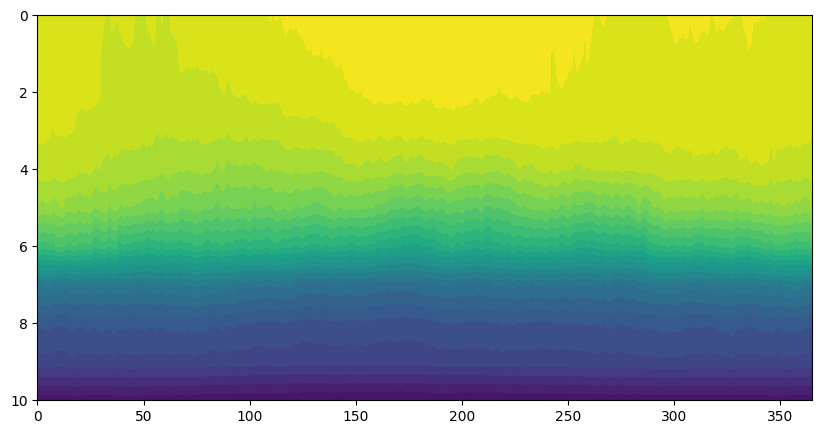

In [185]:
import matplotlib.pyplot as plt
fig , ax = plt.subplots(figsize=(10,5))
ax.contourf(ds_prom.T_20,29);
# Invertimos el eje y
ax.invert_yaxis()



---
# GRAFICAMOS

---




In [206]:
from scipy.ndimage import gaussian_filter # Para realizar un suavizado
import datetime
def Clim(data,sigma):
  fig, ax = plt.subplots(figsize=(7, 7))
  # Definir niveles de temperatura
  levels = np.arange(7, 30, 1)
  # -----------------------------------------------------------------------------------------
  # Suavizado de contornos y countor fill
  sigma = sigma
  temp_smooth = gaussian_filter(data, sigma=sigma)
  # -----------------------------------------------------------------------------------------
  # Graficar mapa de colores suavizado
  cs = ax.contourf(data.dayofyear, data.depth, temp_smooth, levels, cmap="Spectral_r") # RdBu_r

  # Definir niveles de las líneas de contorno
  black_levels = [10, 12, 15, 20, 27,28]
  grey_levels = [level for level in levels if level not in black_levels]

  # Líneas de contorno con suavizado
  cs2 = ax.contour(data.dayofyear, data.depth, temp_smooth, colors='black', levels=black_levels, linewidths=0.65, linestyles='-')
  cs3 = ax.contour(data.dayofyear, data.depth, temp_smooth, colors='whitesmoke', levels=grey_levels, linewidths=0.5, linestyles='-')

  # Agregar etiquetas a las líneas de contorno
  ax.clabel(cs2, fmt='%2.0f', colors='black', fontsize=10)
  # -----------------------------------------------------------------------------------------
  # Invertir el eje y y establecer límites y escala del eje y
  ax.invert_yaxis()
  ax.set_ylim(500, 0) # Hasta 500m de profundidad
  ax.set_yticks(range(0, 501, 50))
  # -----------------------------------------------------------------------------------------
  # Agregar barra de colores
  cbar = fig.colorbar(cs, ax=ax, ticks=np.arange(7, 31, 1))
  cbar.outline.set_linewidth(1)
  cbar.ax.tick_params(labelsize=8)
  # cbar.outline.set_linestyle('--')
  # -----------------------------------------------------------------------------------------
  # # Cambiar etiquetas del eje x a los nombres de los meses
  months = [datetime.date(2000, m, 1).strftime('%b') for m in range(1, 13)]
  ax.set_xticks(np.linspace(1, 365-31, num=12))
  ax.set_xticklabels(months, fontsize = 10)
  #-----------------------------------------------------------------------------------------
  # ESTILO :V
  ax.set_title('Temperatura [°C] Sub Superficial del mar\nPromedio histórico diario (1991-2020) - Boya: 0N 170W',  style="oblique", fontsize=10, color = 'black')
  ax.xaxis.label.set_color('black')
  ax.yaxis.label.set_color('black')
  ax.tick_params(colors='black')

  plt.xticks(fontsize = 8, style="oblique")
  plt.yticks(fontsize = 8, style="oblique")
  ax.set_xlabel('')

  plt.text(0, -0.08, 'Fuente de datos: NOAA [TAO/TRITON]',  style="oblique", fontsize=10, ha='left',
        va='center', color='black', transform=plt.gca().transAxes)
  #-----------------------------------------------------------------------------------------

  fig.savefig(path + f'PerfilTempSub.jpg',
                  transparent = False, pad_inches = 0.1, dpi = 700, bbox_inches = 'tight')
  # Mostrar gráfico
  plt.show()
  plt.close()

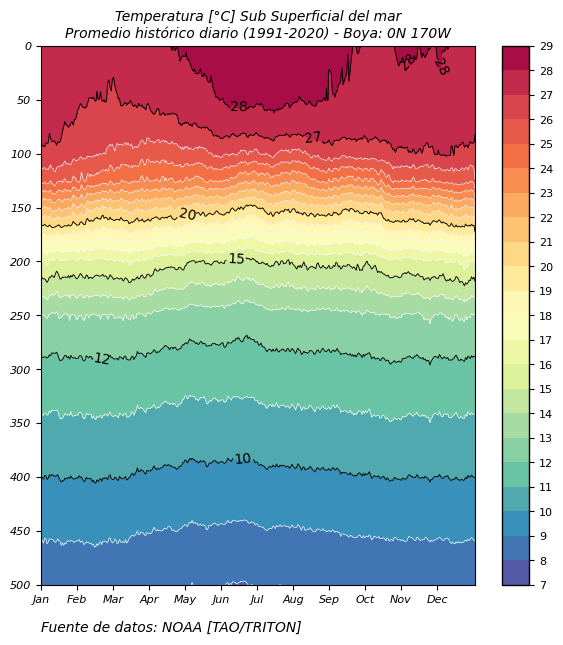

In [207]:
Clim(ds_prom.T_20,0) # Aumentando el valor de 0 puedes cambiar el suavizado.

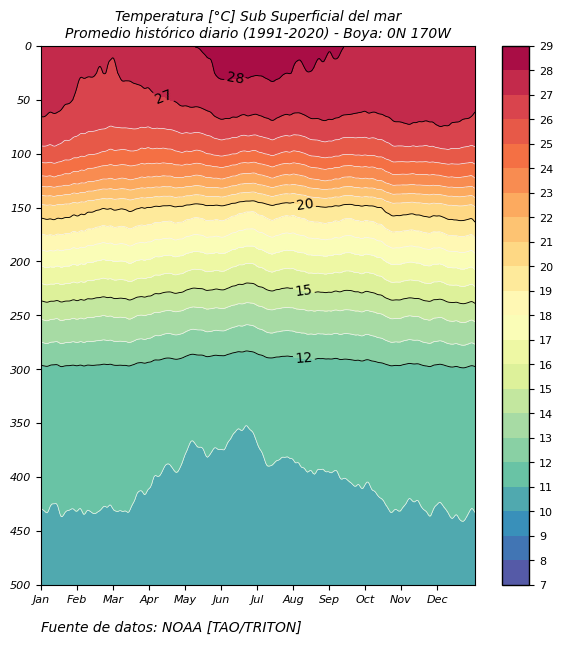

In [208]:
Clim(ds_prom.T_20,1.5) # Tener cuidado con el suavizado.



---
# Los datos utilizados se encuentran en el siguiente link:
https://drive.google.com/drive/folders/1zo4Uq3XS9KKn_I2Ei1J_FiYu4QryQnNt



---

